## Read me

1. ``pip install tensorflow``

2. Put data files in
``cancer-net/pnet/_database``
which can be downloaded from Google Drive [here](https://drive.google.com/uc?id=17nssbdUylkyQY1ebtxsIw5UzTAd0zxWb&export=download).

3. To install pysr, use ``conda install -c conda-forge pysr``



In [1]:
%cd ../pnet
import os
wd = os.path.dirname(os.getcwd())
os.environ['PYTHONPATH'] = wd

/mnt/ceph/users/zzhang/cancer-net/pnet


In [2]:
import imp
import tensorflow as tf
import pandas as pd
import numpy as np

import pysr

from config_path import PROSTATE_LOG_PATH, POSTATE_PARAMS_PATH
from model.model_factory import get_model
from model.nn import Model
from model.builders.builders_utils import get_map_from_layer, get_layer_maps

from data.data_access import Data
from data.prostate_paper.data_reader import ProstateDataPaper, load_data_type
from data.prostate_paper import data_reader
from data.pathways.reactome import ReactomeNetwork


from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score, f1_score, accuracy_score, \
    precision_score, recall_score

2022-06-05 23:45:04.812429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/sw/pkg/devel/gcc/7.4.0/lib:/cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-06-05 23:45:04.812456: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-528xd_at because the default path (/home/zzhang/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
params_file = './pnet/onsplit_average_reg_10_tanh_large_testing'
log_dir = os.path.join(PROSTATE_LOG_PATH, params_file)
log_dir = log_dir
params_file = os.path.join(POSTATE_PARAMS_PATH, params_file)

params_file_full = params_file + '.py'
print(params_file_full)
params = imp.load_source(params_file, params_file_full)

/mnt/ceph/users/zzhang/cancer-net/pnet/train/params/P1000/./pnet/onsplit_average_reg_10_tanh_large_testing.py


In [4]:
# manually adjusted P-net model params
n_hidden_layers = 2
params.models[0]['params']['model_params']['n_hidden_layers'] = n_hidden_layers
params.models[0]['params']['model_params']['w_reg'] = [0.001] * (n_hidden_layers+1)
params.models[0]['params']['model_params']['w_reg_outcomes'] = [0.001] * (n_hidden_layers+1)
params.models[0]['params']['model_params']['dropout'] = [0.5]+[0.1] * (n_hidden_layers+1)
params.models[0]['params']['model_params']['loss_weights'] = [2] * (n_hidden_layers-6) + [2, 7, 20, 54, 148, 400]

In [5]:
# model inherits a sklearn BaseEstimator
model = Model(**params.models[0]['params'])
model.get_params()

{'model_params': {'use_bias': True,
  'w_reg': [0.001, 0.001, 0.001],
  'w_reg_outcomes': [0.001, 0.001, 0.001],
  'dropout': [0.5, 0.1, 0.1, 0.1],
  'loss_weights': [2, 7, 20, 54, 148, 400],
  'optimizer': 'Adam',
  'activation': 'tanh',
  'data_params': {'id': 'ALL',
   'type': 'prostate_paper',
   'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'],
    'drop_AR': False,
    'cnv_levels': 3,
    'mut_binary': True,
    'balanced_data': False,
    'combine_type': 'union',
    'use_coding_genes_only': True,
    'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv',
    'training_split': 0}},
  'add_unk_genes': False,
  'shuffle_genes': False,
  'kernel_initializer': 'lecun_uniform',
  'n_hidden_layers': 2,
  'attention': False,
  'dropout_testing': False},
 'fitting_params': {'samples_per_epoch': 10,
  'select_best_model': False,
  'monitor': 'val_o6_f1',
  'verbose': 2,
  'epoch': 300,
  'shuffle': True,
  'batch_size': 50,
  'save_name': 'pnet',
  'debug

In [6]:
ret = model.build_fn(**model.model_params)
pnet_mod, feature_names, reactome_map = ret

{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_del', 'cnv_amp'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csv', 'training_split': 0}}
n_hidden_layers 2


/mnt/ceph/users/zzhang/cancer-net/pnet/data/prostate_paper/data_reader.py:65: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]
/mnt/ceph/users/zzhang/cancer-net/pnet/data/prostate_paper/data_reader.py:65: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]
/mnt/ceph/users/zzhang/cancer-net/pnet/data/prostate_paper/data_reader.py:65: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]


(1011, 27687)
(1011, 1)
(1011,)
(27687,)
input dimension 27687 self.units 9229
n_inputs_per_node 3
self.kernel_initializer <tensorflow.python.keras.regularizers.L2 object at 0x7fffc861dca0> <tensorflow.python.keras.initializers.initializers_v2.LecunUniform object at 0x7fffc861dfa0> <tensorflow.python.keras.regularizers.L2 object at 0x7fffc861dca0>


2022-06-05 23:46:09.184477: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-06-05 23:46:09.288271: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:af:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-05 23:46:09.288456: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/sw/pkg/devel/gcc/7.4.0/lib:/cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-06-05 23:46:09.288588: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such f

input dimensions (None, 27687)
pathways 146
genes 10621
pathways 26
genes 147
pathways 1
genes 26
original dropout [0.5, 0.1, 0.1, 0.1]
dropout [1, 2] [0.5, 0.1, 0.1, 0.1] [0.001, 0.001, 0.001]
layer 0, dropout  0.1 w_reg 0.001
layer 1, dropout  0.1 w_reg 0.001
Compiling...
loss_weights [2, 7, 20, 54, 148, 400]
[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fffb71cae50>, <model.layers_custom.Diagonal object at 0x7fffc861de50>, <tensorflow.python.keras.layers.core.Dropout object at 0x7fff8d755520>, <model.layers_custom.SparseTF object at 0x7fffa6eeb2e0>, <tensorflow.python.keras.layers.core.Dropout object at 0x7fff7c73ee80>, <model.layers_custom.SparseTF object at 0x7fff7c753be0>, <tensorflow.python.keras.layers.core.Dense object at 0x7fff8d7559d0>, <tensorflow.python.keras.layers.core.Dense object at 0x7fffa6eeb430>, <tensorflow.python.keras.layers.core.Dense object at 0x7fff84b36af0>, <tensorflow.python.keras.layers.core.Activation object at 0x7fff8d755550>, <ten

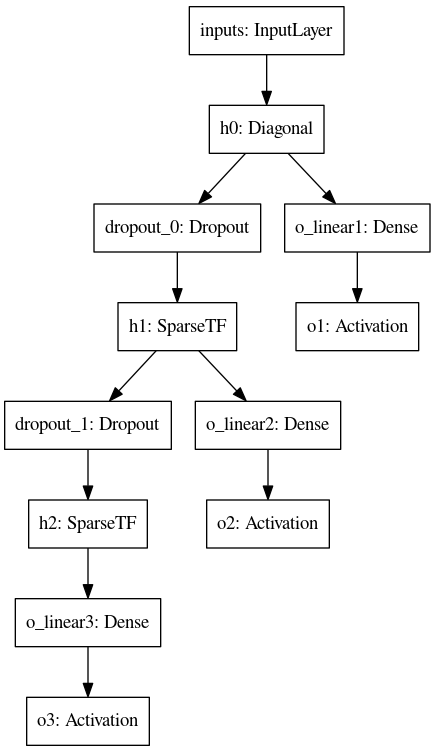

In [7]:
tf.keras.utils.plot_model(pnet_mod)

In [8]:
data = Data(**params.data[0])

x_train, x_validate_, x_test_, y_train, y_validate_, y_test_, info_train, info_validate_, info_test_, cols = data.get_train_validate_test()

print(x_train.shape)

/mnt/ceph/users/zzhang/cancer-net/pnet/data/prostate_paper/data_reader.py:65: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]
/mnt/ceph/users/zzhang/cancer-net/pnet/data/prostate_paper/data_reader.py:65: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]
/mnt/ceph/users/zzhang/cancer-net/pnet/data/prostate_paper/data_reader.py:65: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]


(807, 27687)


In [9]:
pnet_mod.fit(
    x_train, y_train,
    validation_data=(x_validate_, y_validate_),
    epochs=20,
    batch_size=10,
    verbose=0
)

2022-06-05 23:46:15.325588: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-05 23:46:15.344934: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400000000 Hz


input dimensions (None, 27687)
input dimensions (None, 27687)
input dimensions (None, 27687)


In [10]:
y_hat = pnet_mod.predict(x_test_)
print([y.shape for y in y_hat])

input dimensions (None, 27687)
[(102, 1), (102, 1), (102, 1)]


In [11]:
ys = y_test_.flatten()
outs = y_hat[-1]

fpr_valid, tpr_valid, _ = roc_curve(ys, outs)
test_auc = auc(fpr_valid, tpr_valid)

print('accuracy', accuracy_score(ys, outs>0.5))
print('auc', test_auc)
print('aupr', average_precision_score(ys, outs))
print('f1', f1_score(ys, outs>0.5))
print('precision', precision_score(ys, outs>0.5))
print('recall', recall_score(ys, outs>0.5))

accuracy 0.8921568627450981
auc 0.9541522491349481
aupr 0.9186508352359745
f1 0.819672131147541
precision 0.9259259259259259
recall 0.7352941176470589


In [12]:
layer_dict = {x.name:x for x in pnet_mod.layers}
explain_mod = tf.keras.models.Model(
    inputs=pnet_mod.inputs,
    outputs=[layer_dict['h0'].output, layer_dict['h1'].output, layer_dict['h2'].output, layer_dict['o_linear3'].output]
)

In [13]:
reactome = ReactomeNetwork()
pathway_names = reactome.reactome.pathway_names.copy()
pathway_names.index = pathway_names['reactome_id']
pathway_names['pathway_name'] = pathway_names['pathway_name'].str.replace(' ','_').str.replace('-','_')

In [14]:
data_for_pysr = explain_mod.predict(x_train)
print(len(data_for_pysr))

input dimensions (None, 27687)
4


In [15]:
h0 = pd.DataFrame(data_for_pysr[0], columns=reactome_map[0].index)
h1 = pd.DataFrame(data_for_pysr[1], columns=pathway_names.loc[reactome_map[1].index]['pathway_name'])
h2 = pd.DataFrame(data_for_pysr[2], columns=pathway_names.loc[reactome_map[2].index]['pathway_name'])
out = pd.DataFrame(data_for_pysr[3], columns=['out'])

In [16]:
h1 = (h1-h1.mean())/(h1.std())

In [17]:
tmp = h1.join(out)
tmp_corr = tmp.corr()['out'].abs().sort_values(ascending=False).drop('out')
tmp_corr.head(20)

Post_translational_protein_modification         0.951776
RNA_Polymerase_II_Transcription                 0.941051
Cellular_responses_to_stress                    0.834714
Signaling_by_Rho_GTPases                        0.813514
Innate_Immune_System                            0.783222
Adaptive_Immune_System                          0.756830
Cytokine_Signaling_in_Immune_system             0.723834
Metabolism_of_lipids                            0.718479
Membrane_Trafficking                            0.715939
Intracellular_signaling_by_second_messengers    0.695141
Signaling_by_GPCR                               0.691544
Axon_guidance                                   0.676864
Signaling_by_Receptor_Tyrosine_Kinases          0.648621
Signaling_by_WNT                                0.629330
Signaling_by_NOTCH                              0.620109
Diseases_of_signal_transduction                 0.617654
Cell_Cycle_Checkpoints                          0.604573
Infectious_disease             

In [18]:
tmp[tmp_corr.head(20).index].corr().round(3)

,Post_translational_protein_modification,RNA_Polymerase_II_Transcription,Cellular_responses_to_stress,Signaling_by_Rho_GTPases,Innate_Immune_System,Adaptive_Immune_System,Cytokine_Signaling_in_Immune_system,Metabolism_of_lipids,Membrane_Trafficking,Intracellular_signaling_by_second_messengers,Signaling_by_GPCR,Axon_guidance,Signaling_by_Receptor_Tyrosine_Kinases,Signaling_by_WNT,Signaling_by_NOTCH,Diseases_of_signal_transduction,Cell_Cycle_Checkpoints,Infectious_disease,Death_Receptor_Signalling,Metabolism_of_amino_acids_and_derivatives
Post_translational_protein_modification,1.000,0.922,-0.870,-0.844,0.717,0.687,0.599,0.613,0.667,0.628,-0.609,0.588,0.537,0.528,-0.546,-0.545,-0.548,-0.517,-0.473,-0.474
RNA_Polymerase_II_Transcription,0.922,1.000,-0.870,-0.837,0.640,0.671,0.577,0.606,0.576,0.656,-0.561,0.568,0.534,0.545,-0.563,-0.579,-0.531,-0.471,-0.443,-0.456
Cellular_responses_to_stress,-0.870,-0.870,1.000,0.926,-0.514,-0.501,-0.473,-0.419,-0.437,-0.500,0.476,-0.406,-0.374,-0.427,0.500,0.382,0.503,0.365,0.375,0.405
Signaling_by_Rho_GTPases,-0.844,-0.837,0.926,1.000,-0.530,-0.478,-0.450,-0.442,-0.462,-0.415,0.525,-0.418,-0.411,-0.433,0.403,0.355,0.343,0.390,0.499,0.378
Innate_Immune_System,0.717,0.640,-0.514,-0.530,1.000,0.688,0.605,0.597,0.766,0.496,-0.639,0.721,0.651,0.635,-0.500,-0.528,-0.464,-0.635,-0.580,-0.582
Adaptive_Immune_System,0.687,0.671,-0.501,-0.478,0.688,1.000,0.569,0.600,0.684,0.675,-0.610,0.611,0.581,0.580,-0.485,-0.536,-0.446,-0.558,-0.542,-0.502
Cytokine_Signaling_in_Immune_system,0.599,0.577,-0.473,-0.450,0.605,0.569,1.000,0.604,0.587,0.552,-0.583,0.529,0.470,0.469,-0.586,-0.409,-0.592,-0.523,-0.534,-0.375
Metabolism_of_lipids,0.613,0.606,-0.419,-0.442,0.597,0.600,0.604,1.000,0.616,0.570,-0.591,0.597,0.554,0.487,-0.395,-0.470,-0.429,-0.501,-0.444,-0.445
Membrane_Trafficking,0.667,0.576,-0.437,-0.462,0.766,0.684,0.587,0.616,1.000,0.443,-0.663,0.703,0.625,0.578,-0.429,-0.446,-0.439,-0.701,-0.557,-0.596
Intracellular_signaling_by_second_messengers,0.628,0.656,-0.500,-0.415,0.496,0.675,0.552,0.570,0.443,1.000,-0.441,0.434,0.522,0.467,-0.611,-0.531,-0.651,-0.389,-0.394,-0.354


In [19]:
# Dataset
X_for_pysr = tmp[tmp_corr.head(20).index]
y_for_pysr = data_for_pysr[3]

default_pysr_params = dict(
    populations=30,
    procs=4,
    model_selection="best",
)


In [20]:
# Learn equations
model = pysr.PySRRegressor(
        niterations=30,
        binary_operators=["plus", "sub", "mult", "div", "greater"],
        unary_operators=["neg", "square"],
        **default_pysr_params)

model.fit(X_for_pysr, y_for_pysr)

/mnt/home/zzhang/anaconda3/envs/cancerenv/lib/python3.9/site-packages/pysr/sr.py:1048: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/mnt/home/zzhang/anaconda3/envs/cancerenv/lib/python3.9/site-packages/pysr/sr.py:1561: UserWarning: Note: you are running with 10 features or more. Genetic algorithms like used in PySR scale poorly with large numbers of features. Consider using feature selection techniques to select the most important features (you can do this automatically with the `select_k_features` parameter), or, alternatively, doing a dimensionality reduction beforehand. For example, `X = PCA(n_components=6).fit_transform(X)`, using scikit-learn's `PCA` class, will reduce the number of features to 6 in an interpretable way, as each resultant feature will be a linear combination of the original features. 
  warnings.warn(
  Activating environment at `~/.julia/environments/pysr-0.9.0/Project.toml`
   Resolving packag

Started!

Cycles per second: 5.210e+04
Head worker occupation: 29.1%
Progress: 145 / 900 total iterations (16.111%)
Hall of Fame:
-----------------------------------------
Complexity  loss       Score     Equation
1           8.385e+00  2.980e-01  Post_translational_protein_modification
3           3.777e+00  3.988e-01  (RNA_Polymerase_II_Transcription * 3.1646957)
4           3.547e+00  6.264e-02  neg(Post_translational_protein_modification * -3.2007647)
5           1.292e+00  1.010e+00  ((RNA_Polymerase_II_Transcription / 0.3160312) - 1.57582)
7           7.450e-01  2.754e-01  (((RNA_Polymerase_II_Transcription / 0.38652864) + Cytokine_Signaling_in_Immune_system) - 1.5760914)
9           4.357e-01  2.682e-01  ((Cytokine_Signaling_in_Immune_system + ((RNA_Polymerase_II_Transcription + Post_translational_protein_modification) * 1.3497416)) + -1.5760964)
11          4.102e-01  3.021e-02  ((((Post_translational_protein_modification + Cytokine_Signaling_in_Immune_system) / 1.2603804) + (R

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000            Post_translational_protein_modification   
	1        0.430115  (Post_translational_protein_modification / 0.3...   
	2  >>>>  0.602462  ((Post_translational_protein_modification / 0....   
	3        0.231821  (((Post_translational_protein_modification / 0...   
	4        0.214196  ((Cytokine_Signaling_in_Immune_system + ((RNA_...   
	5        0.043645  (((Cytokine_Signaling_in_Immune_system * 0.761...   
	6        0.183055  ((((RNA_Polymerase_II_Transcription + (Cytokin...   
	7        0.130773  ((((Innate_Immune_System + (Cytokine_Signaling...   
	8        0.106150  ((((Innate_Immune_System + ((Cytokine_Signalin...   
	9        0.018420  ((((Innate_Immune_System + ((Cytokine_Signalin...   
	
	       loss  complexity  
	0  8.384591           1  
	1  3.547228           3  
	2  1.063156           5  
	3  0.668713           7  
	4  0.435704           9  
	5  

In [21]:
model.equations_.sort_values("score", ascending=False)[['complexity', 'loss', 'score', 'equation']]

,complexity,loss,score,equation
2,5,1.063156,0.602462,((Post_translational_protein_modification / 0....
1,3,3.547228,0.430115,(Post_translational_protein_modification / 0.3...
3,7,0.668713,0.231821,(((Post_translational_protein_modification / 0...
4,9,0.435704,0.214196,((Cytokine_Signaling_in_Immune_system + ((RNA_...
6,13,0.276874,0.183055,((((RNA_Polymerase_II_Transcription + (Cytokin...
7,15,0.213155,0.130773,((((Innate_Immune_System + (Cytokine_Signaling...
8,17,0.172383,0.106150,((((Innate_Immune_System + ((Cytokine_Signalin...
5,11,0.399284,0.043645,(((Cytokine_Signaling_in_Immune_system * 0.761...
9,19,0.166148,0.018420,((((Innate_Immune_System + ((Cytokine_Signalin...
0,1,8.384591,0.000000,Post_translational_protein_modification


In [23]:
model.sympy(9)

-0.405286278623698*Cellular_responses_to_stress + 0.405286278623698*Cytokine_Signaling_in_Immune_system + 0.405286278623698*Innate_Immune_System + 0.405286278623698*Metabolism_of_lipids + Post_translational_protein_modification + RNA_Polymerase_II_Transcription + 0.280662774378304*Signaling_by_Receptor_Tyrosine_Kinases - 1.5760713

In [24]:
model.sympy()

3.20095424287125*Post_translational_protein_modification - 1.5760814